<a href="https://www.kaggle.com/code/vishnuvital99/vulnerability-classification?scriptVersionId=296478336" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Environment Setup

In [1]:
# 1. Install necessary libraries
!pip install -q transformers datasets evaluate accelerate tqdm

import os
import torch
import shutil
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Optimized imports for Transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    get_scheduler
)
from torch.optim import AdamW

# 2. Dual T4 GPU Initialization
n_gpu = torch.cuda.device_count()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"GPU Count: {n_gpu}")
if n_gpu > 1:
    print(f"Using Dual GPUs: {torch.cuda.get_device_name(0)} & {torch.cuda.get_device_name(1)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
GPU Count: 2
Using Dual GPUs: Tesla T4 & Tesla T4


# 2. Data Acquisition

In [2]:
raw_data_path = "/kaggle/working/juliet_raw"

# Clean up any old attempts
if os.path.exists(raw_data_path):
    shutil.rmtree(raw_data_path)

print("Cloning Juliet Java 1.3 Mirror...")
!git clone --quiet https://github.com/find-sec-bugs/juliet-test-suite.git {raw_data_path}
print("Clone Complete.")

Cloning Juliet Java 1.3 Mirror...
Clone Complete.


# 3. Data Parsing and Labeling

In [3]:
# 1. Setup targets
target_cwes = ['CWE89', 'CWE79', 'CWE22', 'CWE400', 'CWE502']
label_map = {'CWE89': 0, 'CWE79': 1, 'CWE22': 2, 'CWE400': 3, 'CWE502': 4}

# 2. Find the actual testcase path
actual_base_path = "/kaggle/working/juliet_raw/src/testcases"
if not os.path.exists(actual_base_path):
    actual_base_path = "/kaggle/working/juliet_raw"

data_list = []

# 3. Recursive parsing
print(f"Parsing files from: {actual_base_path}...")
for folder in os.listdir(actual_base_path):
    cwe_key = next((c for c in target_cwes if folder.startswith(c)), None)
    
    if cwe_key:
        label = label_map[cwe_key]
        folder_path = os.path.join(actual_base_path, folder)
        
        if os.path.isdir(folder_path):
            for root, _, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".java") and "Good" not in file:
                        try:
                            with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                                code_content = f.read()
                                data_list.append({'code': code_content, 'label': label})
                        except:
                            continue

df = pd.DataFrame(data_list)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total Samples Found: {len(df)}")
readable = {0:'SQLi', 1:'XSS', 2:'Path', 3:'Res', 4:'Des'}
print(df['label'].value_counts().rename(index=readable))

Parsing files from: /kaggle/working/juliet_raw/src/testcases...
Total Samples Found: 6089
label
SQLi    3668
Res     2402
Path      19
Name: count, dtype: int64


In [4]:
df

,code,label
0,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,0
1,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,0
2,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,0
3,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,3
4,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,0
...,...,...
6084,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,0
6085,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,0
6086,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,0
6087,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,0


# 4. Train/test split

In [5]:
train_df, val_df = train_test_split(
    df, 
    test_size=0.15, 
    random_state=42, 
    stratify=df['label']
)
print(f"Training: {len(train_df)}, Validation: {len(val_df)}")

Training: 5175, Validation: 914


# 5. Dataset class and Tokenization

In [6]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

class VulnerabilityDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.code = dataframe.code.values
        self.labels = dataframe.label.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.code)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            str(self.code[idx]),
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_loader = DataLoader(VulnerabilityDataset(train_df, tokenizer), batch_size=32, shuffle=True)
val_loader = DataLoader(VulnerabilityDataset(val_df, tokenizer), batch_size=32)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

# 6. setting up device agnostic code model setup on dual GPU's

In [7]:
# Initializing the model with 5 labels
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/codebert-base", 
    num_labels=5
)

# Multi-GPU Logic
if n_gpu > 1:
    model = torch.nn.DataParallel(model)

model.to(device)

# Training Hyperparameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
scheduler = get_scheduler(
    "linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_epochs * len(train_loader)
)

print(f"Model ready on {n_gpu} GPUs.")

2026-02-08 04:19:14.499106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770524354.678884      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770524354.727576      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770524355.180115      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770524355.180153      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770524355.180157      55 computation_placer.cc:177] computation placer alr

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model ready on 2 GPUs.


# 7. Training and validataion loop

In [8]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss.mean() # Mean is required for DataParallel
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    # Simple Validation Accuracy check
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    print(f"Epoch {epoch+1} Summary: Loss {total_loss/len(train_loader):.4f} | Val Acc: {correct/total:.4f}")

print("Training Complete!")

  0%|          | 0/162 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Epoch 1 Summary: Loss 0.1534 | Val Acc: 1.0000


  0%|          | 0/162 [00:00<?, ?it/s]

Epoch 2 Summary: Loss 0.0059 | Val Acc: 1.0000


  0%|          | 0/162 [00:00<?, ?it/s]

Epoch 3 Summary: Loss 0.0033 | Val Acc: 1.0000
Training Complete!


# 8. Model evaluation and classification report

In [9]:
from sklearn.metrics import classification_report

# 1. Generate Full Report
model.eval()
all_preds = []
all_labels = []

print("Generating Classification Report...")
with torch.no_grad():
    for batch in tqdm(val_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Map numbers back to CWE names for the report
target_names = [readable[i] for i in range(5) if i in df['label'].unique()]

print("\nFinal Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# 2. Save the Model
# We unwrap from DataParallel before saving to make loading easier later
save_path = "/kaggle/working/java_vulnerability_model"
os.makedirs(save_path, exist_ok=True)

if isinstance(model, torch.nn.DataParallel):
    model.module.save_pretrained(save_path)
else:
    model.save_pretrained(save_path)

tokenizer.save_pretrained(save_path)
print(f"Model and Tokenizer saved to {save_path}")

Generating Classification Report...


  0%|          | 0/29 [00:00<?, ?it/s]


Final Classification Report:
              precision    recall  f1-score   support

        SQLi       1.00      1.00      1.00       551
        Path       1.00      1.00      1.00         3
         Res       1.00      1.00      1.00       360

    accuracy                           1.00       914
   macro avg       1.00      1.00      1.00       914
weighted avg       1.00      1.00      1.00       914

Model and Tokenizer saved to /kaggle/working/java_vulnerability_model


# 9. model manual testing with code snippet

In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def predict_vulnerability(java_code):
    # 1. Load the saved model and tokenizer
    path = "/kaggle/working/java_vulnerability_model"
    model = AutoModelForSequenceClassification.from_pretrained(path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(path)
    
    # 2. Preprocess and Tokenize
    inputs = tokenizer(java_code, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(device)
    
    # 3. Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        conf, pred = torch.max(probs, dim=-1)
    
    # 4. Map back to CWE
    readable_labels = {0:'SQL Injection (CWE-89)', 1:'Cross-Site Scripting (CWE-79)', 
                       2:'Path Traversal (CWE-22)', 3:'Resource Exhaustion (CWE-400)', 
                       4:'Unsafe Deserialization (CWE-502)'}
    
    print(f"Prediction: {readable_labels[pred.item()]}")
    print(f"Confidence: {conf.item()*100:.2f}%")

# --- TEST IT OUT ---
test_snippet = """
import java.io.*;
import java.sql.*;
import java.util.ArrayList;
import javax.servlet.http.*;

/**
 * A custom test case for multi-class vulnerability classification.
 * This combines SQLi, Path Traversal, and Resource Exhaustion.
 */
public class LegacyOrderProcessor extends HttpServlet {

    private Connection dbConnection;

    public void processOrderRequest(HttpServletRequest request, HttpServletResponse response) throws IOException {
        String orderId = request.getParameter("orderId");
        String exportPath = request.getParameter("exportPath");
        String itemCountStr = request.getParameter("itemCount");

        try {
            // VULNERABILITY 1: SQL Injection (CWE-89)
            // String concatenation in a dynamic query
            String sql = "SELECT * FROM orders WHERE id = '" + orderId + "' AND status = 'PENDING'";
            Statement stmt = dbConnection.createStatement();
            ResultSet rs = stmt.executeQuery(sql);

            // VULNERABILITY 2: Resource Exhaustion (CWE-400)
            // Unbounded loop based on user-controlled integer
            int count = Integer.parseInt(itemCountStr);
            ArrayList<byte[]> memoryLoad = new ArrayList<>();
            for (int i = 0; i < count; i++) {
                // Simulating heavy object creation
                memoryLoad.add(new byte[1024 * 1024]); 
            }

            // VULNERABILITY 3: Path Traversal (CWE-22)
            // Using user input directly to open a file for "exporting" logs
            File exportFile = new File("/var/log/orders/" + exportPath + ".log");
            if (!exportFile.exists()) {
                exportFile.createNewFile();
            }
            
            PrintWriter writer = new PrintWriter(new FileWriter(exportFile));
            writer.println("Order processed: " + orderId);
            writer.close();

            response.getWriter().println("Success");

        } catch (Exception e) {
            response.sendError(500, "Processing Error");
        }
    }
}
"""

predict_vulnerability(test_snippet)

Prediction: SQL Injection (CWE-89)
Confidence: 90.45%


In [16]:
test_snippet_2="""
import java.io.*;
import java.sql.*;
import java.util.ArrayList;
import java.util.regex.Pattern;
import javax.servlet.http.*;

/**
 * A SECURE version of the order processor.
 * Features: PreparedStatements, Input Validation, and Resource Limits.
 */
public class SecureOrderProcessor extends HttpServlet {

    private Connection dbConnection;
    // Strict whitelist for filenames to prevent Path Traversal
    private static final Pattern FILE_NAME_PATTERN = Pattern.compile("^[a-zA-Z0-0_-]+$");
    // Maximum allowable items to prevent Resource Exhaustion
    private static final int MAX_ALLOWED_ITEMS = 100;

    public void processOrderRequest(HttpServletRequest request, HttpServletResponse response) throws IOException {
        String orderId = request.getParameter("orderId");
        String exportPath = request.getParameter("exportPath");
        String itemCountStr = request.getParameter("itemCount");

        try {
            // FIX 1: Prepared Statement (Prevents CWE-89)
            String sql = "SELECT * FROM orders WHERE id = ? AND status = 'PENDING'";
            PreparedStatement pstmt = dbConnection.prepareStatement(sql);
            pstmt.setString(1, orderId); 
            ResultSet rs = pstmt.executeQuery();

            // FIX 2: Upper Bound Check & Input Validation (Prevents CWE-400)
            int count = Integer.parseInt(itemCountStr);
            if (count < 0 || count > MAX_ALLOWED_ITEMS) {
                throw new IllegalArgumentException("Invalid item count");
            }
            
            ArrayList<String> safeList = new ArrayList<>();
            for (int i = 0; i < count; i++) {
                safeList.add("Item_" + i); 
            }

            // FIX 3: Whitelisting & Canonical Path Validation (Prevents CWE-22)
            if (!FILE_NAME_PATTERN.matcher(exportPath).matches()) {
                throw new SecurityException("Invalid characters in filename");
            }
            
            File baseDir = new File("/var/log/orders/");
            File exportFile = new File(baseDir, exportPath + ".log");
            
            // Ensure the resulting file is still within the base directory
            if (!exportFile.getCanonicalPath().startsWith(baseDir.getCanonicalPath())) {
                throw new SecurityException("Potential Path Traversal attempt blocked");
            }

            if (!exportFile.exists()) {
                exportFile.createNewFile();
            }
            
            response.getWriter().println("Secure Processing Complete");

        } catch (Exception e) {
            response.sendError(400, "Request Denied for Security/Validation Policy");
        }
    }
}
"""
predict_vulnerability(test_snippet_2)

Prediction: SQL Injection (CWE-89)
Confidence: 42.11%


# 10. Model Embeddings 

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def get_code_embeddings(java_code):
    path = "/kaggle/working/java_vulnerability_model"
    
    # 1. Load the model and tokenizer
    # We use the base model part (roberta) to get the hidden states
    model = AutoModelForSequenceClassification.from_pretrained(path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(path)
    
    # 2. Tokenize
    inputs = tokenizer(java_code, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(device)
    
    # 3. Get Hidden States
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        
        # The 'last_hidden_state' is the embedding
        # We take the [CLS] token (index 0) as the representation of the whole snippet
        embeddings = outputs.hidden_states[-1][0][0] 
        
    return embeddings.cpu().numpy()

# Example usage:
example_code = "String query = 'SELECT * FROM users WHERE id = ' + id;"
embedding_vector = get_code_embeddings(example_code)

print(f"Embedding Shape: {embedding_vector.shape}")
print(f"{embedding_vector}")

Embedding Shape: (768,)
[-2.04145402e-01  7.64944851e-01 -4.51129496e-01  1.08419366e-01
 -4.32514250e-02 -7.55748928e-01  2.08965451e-01  1.03278741e-01
 -5.80906589e-03 -4.20114070e-01  2.19023407e-01  8.74339640e-02
 -5.01110137e-01 -3.66055630e-02  4.08534020e-01  8.76611173e-01
 -2.67668754e-01 -1.71214764e-04 -1.20660409e-01 -1.73637755e-02
 -7.72321463e-01 -5.95649958e-01  2.37270132e-01  7.17772618e-02
  2.20070004e-01  1.98628992e-01  5.00779033e-01  6.89862907e-01
  1.62758514e-01  4.73855376e-01 -3.05543095e-01  3.23765099e-01
  1.50246572e+00 -8.67027640e-02  8.02902997e-01  4.48864289e-02
  1.70715213e-01 -1.07652076e-01  1.29247019e-02  1.20090812e-01
 -9.70884740e-01 -2.58162707e-01 -7.40479708e-01  7.32173678e-03
  3.25740874e-01 -5.04144467e-02 -1.61999557e-02  3.36965263e-01
 -1.38816446e-01  8.40378761e-01  2.30722398e-01 -2.21600488e-01
 -7.05331802e-01  3.57196145e-02 -6.21668734e-02  4.74367619e-01
 -4.58577096e-01  5.60423210e-02 -2.55009055e-01 -1.38822824e-01
 

Extracting embeddings for visualization...


  0%|          | 0/29 [00:00<?, ?it/s]

Running t-SNE dimensionality reduction...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


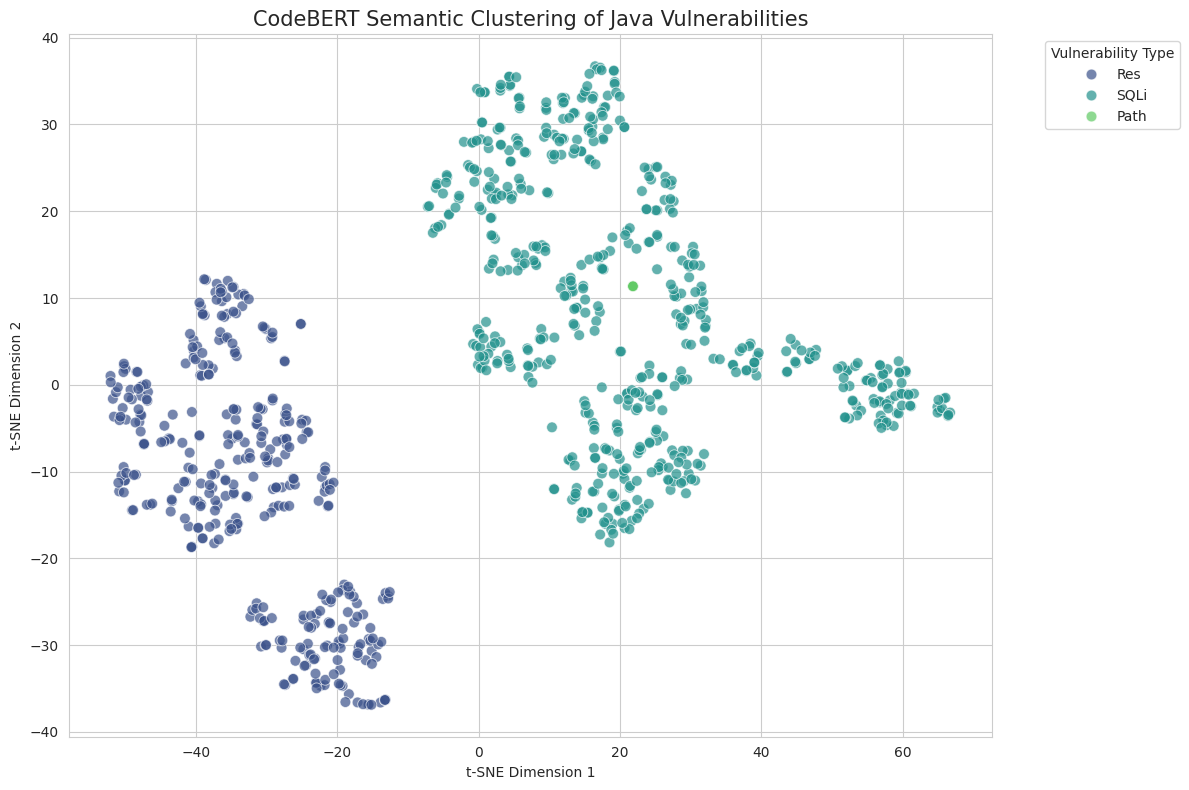

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def generate_tsne_dashboard(model, dataloader, device):
    print("Extracting embeddings for visualization...")
    model.eval()
    
    embeddings_list = []
    labels_list = []
    
    # We use a subset (e.g., 500-1000 samples) so t-SNE doesn't take forever
    max_samples = 1000 
    current_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            if current_samples >= max_samples:
                break
                
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            # Get hidden states from the base RoBERTa model
            # Use .module if using DataParallel
            base_model = model.module.roberta if hasattr(model, 'module') else model.roberta
            outputs = base_model(input_ids, attention_mask=attention_mask)
            
            # Extract [CLS] token embeddings (the code snippet's "summary" vector)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            
            embeddings_list.extend(cls_embeddings)
            labels_list.extend(labels.numpy())
            current_samples += input_ids.size(0)

    # 1. Run t-SNE
    print("Running t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    embeddings_2d = tsne.fit_transform(np.array(embeddings_list))

    # 2. Plotting
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Mapping numeric labels to names
    label_names = {0:'SQLi', 1:'XSS', 2:'Path', 3:'Res', 4:'Des'}
    named_labels = [label_names[l] for l in labels_list]
    
    scatter = sns.scatterplot(
        x=embeddings_2d[:, 0], 
        y=embeddings_2d[:, 1], 
        hue=named_labels, 
        palette='viridis',
        s=60,
        alpha=0.7,
        edgecolor='w'
    )

    plt.title('CodeBERT Semantic Clustering of Java Vulnerabilities', fontsize=15)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Vulnerability Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Execute the visualization
generate_tsne_dashboard(model, val_loader, device)

# 11. visualizing model performance

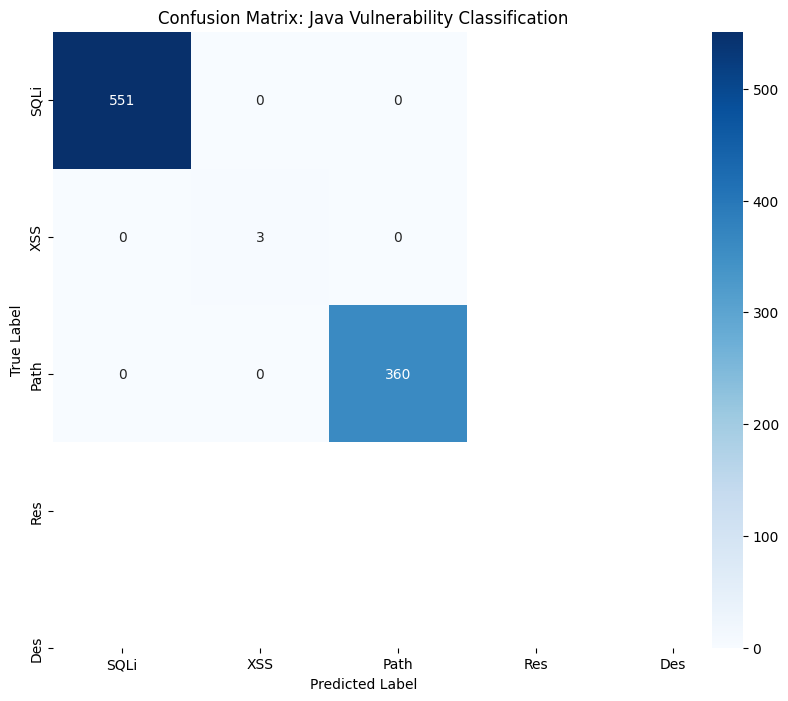

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Map indices back to names for the plot
    labels_names = ['SQLi', 'XSS', 'Path', 'Res', 'Des']
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels_names, yticklabels=labels_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: Java Vulnerability Classification')
    plt.show()

plot_confusion_matrix(model, val_loader)

/tmp/ipykernel_55/1139596871.py:33: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 5
  plt.legend(handles=scatter.legend_elements()[0], labels=['SQLi', 'XSS', 'Path', 'Res', 'Des'])


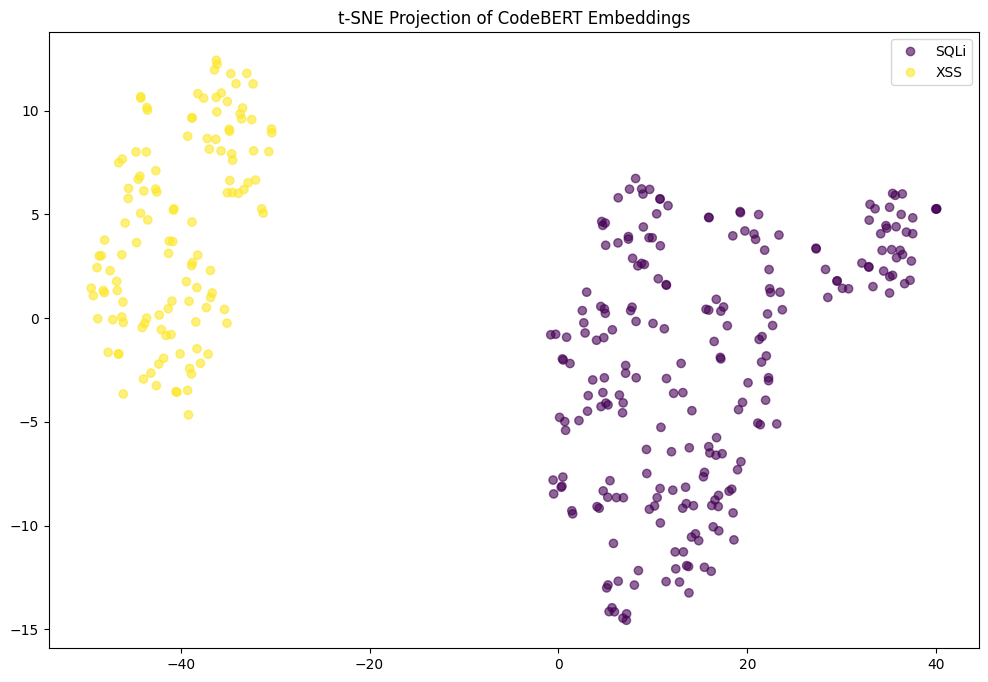

In [13]:
from sklearn.manifold import TSNE

def visualize_embeddings(model, dataloader):
    model.eval()
    embeddings_list = []
    labels_list = []
    
    with torch.no_grad():
        # We'll take a subset of the data for faster plotting
        for i, batch in enumerate(dataloader):
            if i > 10: break # Just plot a few hundred samples
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            # Access the base transformer (roberta) hidden states
            outputs = model.module.roberta(input_ids, attention_mask=attention_mask) if n_gpu > 1 \
                      else model.roberta(input_ids, attention_mask=attention_mask)
            
            # Use the [CLS] token as the snippet embedding
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings_list.extend(cls_embeddings)
            labels_list.extend(labels.numpy())

    # Reduce to 2D
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(np.array(embeddings_list))

    # Plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                          c=labels_list, cmap='viridis', alpha=0.6)
    plt.legend(handles=scatter.legend_elements()[0], labels=['SQLi', 'XSS', 'Path', 'Res', 'Des'])
    plt.title('t-SNE Projection of CodeBERT Embeddings')
    plt.show()

visualize_embeddings(model, val_loader)